# Rate Simulation

This notebook is going to cover the logic of the yield curve simulation that was performed using the results of the PCA.

## Getting the Data

Since we already performed the PCA and saved cleaned yield curves as well as PCA factors and loadings, we can simply load these results in from our processed data file and load them in a dataframe.  

In [1]:
import pandas as pd
import os

cleaned_yield_curves_path = os.path.join("../", "data", "processed", "cleaned_data.csv")
pca_factors_path = os.path.join("../", "data", "processed", "pca_factors.csv")
pca_loadings_path = os.path.join("../", "data", "processed", "pca_loadings.csv")

cleaned_yield_curves = pd.read_csv(cleaned_yield_curves_path, index_col=0, parse_dates=True)
pca_factors = pd.read_csv(pca_factors_path, index_col=0)
pca_loadings = pd.read_csv(pca_loadings_path, index_col=0)

Now that we have the data, let's take a look at the head of each dataframe to ensure they are reading as expected.

In [2]:
print(cleaned_yield_curves.head())
print(pca_factors.head())
print(pca_loadings.head())

             1MO   3MO   6MO    1Y    2Y    3Y    5Y    7Y   10Y   20Y   30Y
date                                                                        
2001-07-31  3.67  3.54  3.47  3.53  3.79  4.06  4.57  4.86  5.07  5.61  5.51
2001-08-01  3.65  3.53  3.47  3.56  3.83  4.09  4.62  4.90  5.11  5.63  5.53
2001-08-02  3.65  3.53  3.46  3.57  3.89  4.17  4.69  4.97  5.17  5.68  5.57
2001-08-03  3.63  3.52  3.47  3.57  3.91  4.22  4.72  4.99  5.20  5.70  5.59
2001-08-06  3.62  3.52  3.47  3.56  3.88  4.17  4.71  4.99  5.19  5.70  5.59
                 PC1       PC2       PC3
date                                    
2001-08-01  0.092105 -0.028274 -0.024454
2001-08-02  0.158519 -0.029538 -0.006901
2001-08-03  0.068216 -0.028475 -0.016042
2001-08-06 -0.038705 -0.012517  0.024251
2001-08-07  0.033413  0.002951  0.000256
            PC1       PC2       PC3
tenor                              
1MO    0.089822  0.737671  0.513798
3MO    0.103743  0.446896 -0.049528
6MO    0.135604  0.294766 -0.2

## Fitting a Model

Great — the data is loaded just as expected. Now we get to the fun part! To simulate future yield curves, we need to simulate how the factors evolve over time. To do this, we’ll use a Vector Autoregression (VAR) model.

A VAR is a time-series model used for multivariate data — meaning it models multiple time series together rather than individually. Like a standard autoregressive (AR) model, a VAR predicts future values using linear combinations of past values. But unlike a univariate AR model, a VAR captures feedback and interdependence among all variables in the system.

That’s exactly what we need here: our three principal components (Level, Slope, Curvature) often move together and influence one another. A VAR lets us model these joint dynamics in a single system.

Since PCA was performed on daily yield changes, the VAR models daily changes in the Level, Slope, and Curvature factors.

The formula for a $VAR(k)$ looks like this:

$$
\mathbf{f}_t = c + \mathbf{A}_1 \mathbf{f}_{t-1} + \mathbf{A}_2 \mathbf{f}_{t-2} + \ldots + \mathbf{A}_k \mathbf{f}_{t-k} + \mathbf{e}_t
$$

In this formula, $\mathbf{f}_t$ is the factors at time $t$, $c$ is a vector of constants (intercepts), $A_1, \ldots, A_k$, are $p \times p$ matrices, and $\mathbf{e}_t$ is a vector of error terms.

We will start by simply initializing the model. To do so, we can use statsmodels to access a lot of helpful model fitting methods and objects.

In [3]:
# Initializing the model
from statsmodels.tsa.api import VAR

model = VAR(pca_factors.values)

From the formula of VAR, you can see that there are a couple of model parameters that we must tune in order to get the best fitting model we can. Maily, we need to determin the lag for our time series model (i.e. how many of the past $f$ terms we are going to consider in our regression). Luckily, the statmodels library makes that a very easy process for us. We can simply use the select_order method to get a table of AIC and BIC values for each lag. 

In [4]:
model.select_order(maxlags=15).summary()

,AIC,BIC,FPE,HQIC
0,-15.17,-15.17,2.570e-07,-15.17
1,-15.21,-15.20*,2.483e-07,-15.20
2,-15.21,-15.19,2.474e-07,-15.20
3,-15.23,-15.20,2.437e-07,-15.22
4,-15.23,-15.19,2.428e-07,-15.22
5,-15.24,-15.19,2.414e-07,-15.22
6,-15.24,-15.18,2.415e-07,-15.22
7,-15.24,-15.17,2.415e-07,-15.21
8,-15.24,-15.16,2.415e-07,-15.21
9,-15.24,-15.15,2.410e-07,-15.21


The information criteria present a common pattern: AIC favors large lag orders, BIC favors a small lag order, and HQIC lies between them. Because the criteria flatten quickly and BIC selects Lag 1, and because PCA factor dynamics typically exhibit fast-decaying autocorrelation, we select a VAR(1) model as the appropriate order as the increase in the complexity of the model at higher lags does not justify the improvements in performance. Now, we can fit the model using this lag.

In [5]:
var_result = model.fit(1)
var_result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Nov, 2025
Time:                     13:29:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -15.1992
Nobs:                     6341.00    HQIC:                  -15.2076
Log likelihood:           21249.2    FPE:                2.47463e-07
AIC:                     -15.2120    Det(Omega_mle):     2.46996e-07
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.000014         0.001819           -0.008           0.994
L1.y1        -0.009404         0.012552           -0.749           0.454
L1.y2         0.075414         0.025525            2.955           0.003
L1.y3        -0.030352

Now that we have fit the model, we need to run a couple test to ensure that our fit is stable and our residuals are not showing signs of autocorrelation. To test stability, we can simply use the statsmodel check.

In [6]:
var_result.is_stable(verbose=True)

Eigenvalues of VAR(1) rep
0.16848831769844827
0.00836430125480615
0.00836430125480615


np.True_

The eigenvalues all lie within the unit circles, so it appears the model is stable.

Next, we will run diagnostic on the residuals. In a VAR(1) model, we want the residuals of the model to look like white noise since the model runs under the assumption that our error term is normally distributed around 0 and has constant covariance. Structure in the residuals would signal that there is some relationship that our model is not capturing.

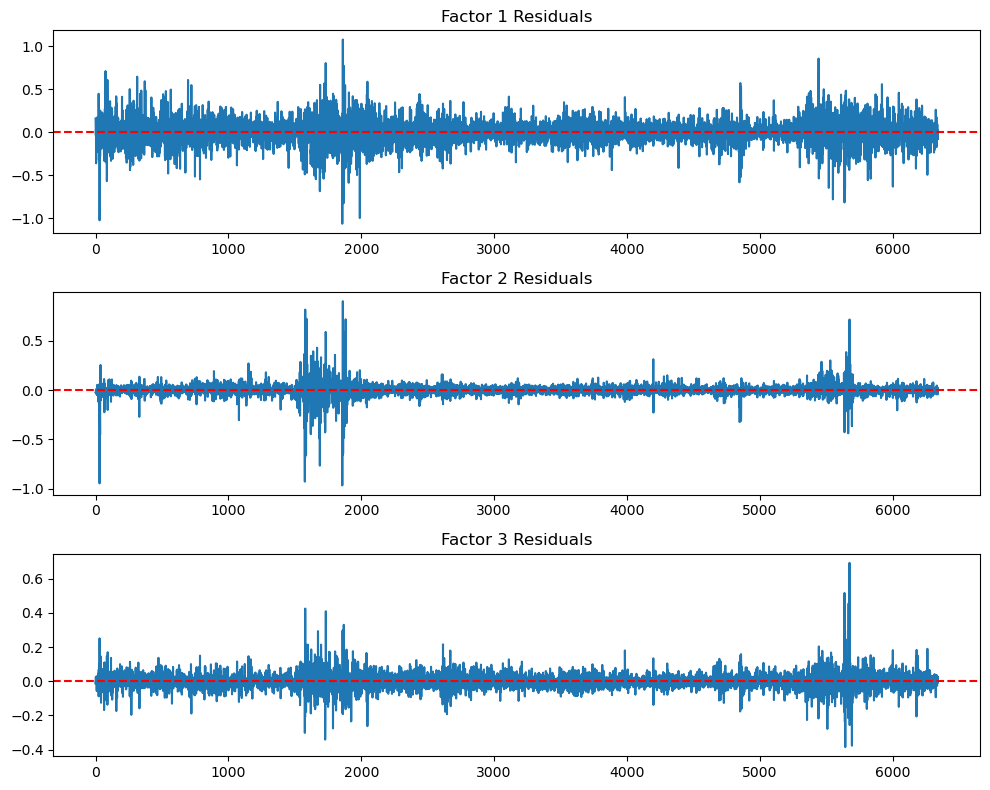

In [7]:
import matplotlib.pyplot as plt

residuals = pd.DataFrame(var_result.resid, columns=['Factor 1 Residuals', 'Factor 2 Residuals', 'Factor 3 Residuals'])

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
for i, column in enumerate(residuals.columns):
    axes[i].plot(residuals.index, residuals[column])
    axes[i].set_title(column)
    axes[i].axhline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()

The residual plots for all three PCA factors show no visible autocorrelation or trend, with fluctuations centered tightly around zero. While there are occasional volatility spikes, the overall pattern is consistent with white noise. This indicates that the VAR(1) specification captures the dynamics of the daily factor changes well and is appropriate for simulation.

## Simulating of Curves

Now that we have a model that appears to explain our factors well, we can turn our attention toward simulation. In order to simulate yield curves for later analysis, we first need to extract the important pieces for the VAR(1) model including our intercept vector, transition matrix, covariance of residuals, and starting state (for this we will use the last PCA factor).

In [8]:
A = var_result.coefs[0]
c = var_result.intercept
Sigma = var_result.sigma_u
initial_state = pca_factors.values[-1]

Now that we have these pieces, our main efforts go towards simulating the residual terms for each future step. Since the VAR(1) model runs under the assumption that this residual term is mutivariate normal with mean 0 and a specified $\Sigma$. We can use Monte Carlo to simulate the residuals and back this into simulated yield curves.

In [9]:
import numpy as np

n_steps = 252 # Simulate for one year
n_simulations = 1000 # Number of simulation paths

# Preallocate array to hold simulated factors
simulated_factors = np.zeros((n_simulations, n_steps, pca_factors.shape[1]))

In [10]:
# Set initial state for all simulations
simulated_factors[:, 0, :] = initial_state
for sim in range(n_simulations):
    for step in range(1, n_steps):
        # Sample epsilon from multivariate normal
        epsilon = np.random.multivariate_normal(mean=np.zeros(pca_factors.shape[1]), cov=Sigma)
        # Update state
        simulated_factors[sim, step, :] = c + A @ simulated_factors[sim, step - 1, :] + epsilon

Now, this leaves us with a 3-D array of all of the factors for our simulation. Now that we have our simulated facotrs, we can back this back into a simulated yield curve. To do this, we can simply multiply our factors by our loadings to get the simulated change in yield for each maturity for each day. From here, we can simply sum the changes in yield for each maturity up to that point to get the total change in yield of each maturity up to that time. From here, we can simply add the base curve for which we will use the last known yield curve to get the results.

$$
y_t^{(n)} = y_{last} + \sum_{s=1}^t Lf_s
$$

In [11]:
simulated_diff_yields = simulated_factors @ pca_loadings.values.T
simulated_cumulative_yields = np.cumsum(simulated_diff_yields, axis=1)
base_curve = cleaned_yield_curves.values[-1]
simulated_yields = simulated_cumulative_yields + base_curve

Great, now we have a 3-D numpy array of all of our simulated yields curves. The dimension of this array are (n x t x m). This can be a bit unweildly for downstream calculation and saving, so let's instead tranfer this into a dataframe. To do this, we need to make dates for our 252 simulated days. To do this, we will use the last date from our cleaned yield curves and create a series of 252 dates forward.

In [12]:
last_date = cleaned_yield_curves.index[-1]
simulated_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_steps, freq='B')

In [13]:
simulated_yields[0]

array([[4.06294562, 3.94064418, 3.78028399, ..., 4.07200604, 4.65842059,
        4.71212431],
       [4.08939184, 3.9571974 , 3.79310566, ..., 4.08333559, 4.66772034,
        4.72045818],
       [4.08438741, 3.97429113, 3.819929  , ..., 4.12146134, 4.69457052,
        4.74150301],
       ...,
       [4.91435823, 3.88624675, 3.34115251, ..., 3.24035921, 4.10068239,
        4.29840664],
       [4.83650242, 3.8375985 , 3.30645239, ..., 3.23784559, 4.10331511,
        4.30245625],
       [4.85616764, 3.83655847, 3.29420151, ..., 3.19368261, 4.06600044,
        4.26956421]], shape=(252, 11))

In [17]:
sim_df = pd.DataFrame(simulated_yields[0], columns=pca_loadings.index)
sim_df.index = simulated_dates
sim_df.index.name = "date"
sim_df["sim_id"] = 0

for i in range(1, n_simulations):
    temp_df = pd.DataFrame(simulated_yields[i], columns=pca_loadings.index)
    temp_df.index.name = "date"
    temp_df.index = simulated_dates
    temp_df["sim_id"] = i
    sim_df = pd.concat([sim_df, temp_df], axis=0)
    
sim_df = sim_df.set_index("sim_id", append=True)

In [18]:
sim_df.head()

,tenor,1MO,3MO,6MO,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
date,sim_id,,,,,,,,,,,
2025-11-21,0,4.062946,3.940644,3.780284,3.630590,3.516219,3.524147,3.644657,3.837297,4.072006,4.658421,4.712124
2025-11-24,0,4.089392,3.957197,3.793106,3.643788,3.530178,3.538468,3.658528,3.850172,4.083336,4.667720,4.720458
2025-11-25,0,4.084387,3.974291,3.819929,3.682877,3.586208,3.595588,3.711479,3.896854,4.121461,4.694571,4.741503
2025-11-26,0,4.039086,3.922983,3.771349,3.630492,3.535728,3.553667,3.688178,3.888330,4.125303,4.713365,4.765596
2025-11-27,0,3.975152,3.873298,3.728177,3.583489,3.484916,3.504307,3.645511,3.852734,4.097583,4.695643,4.752207
